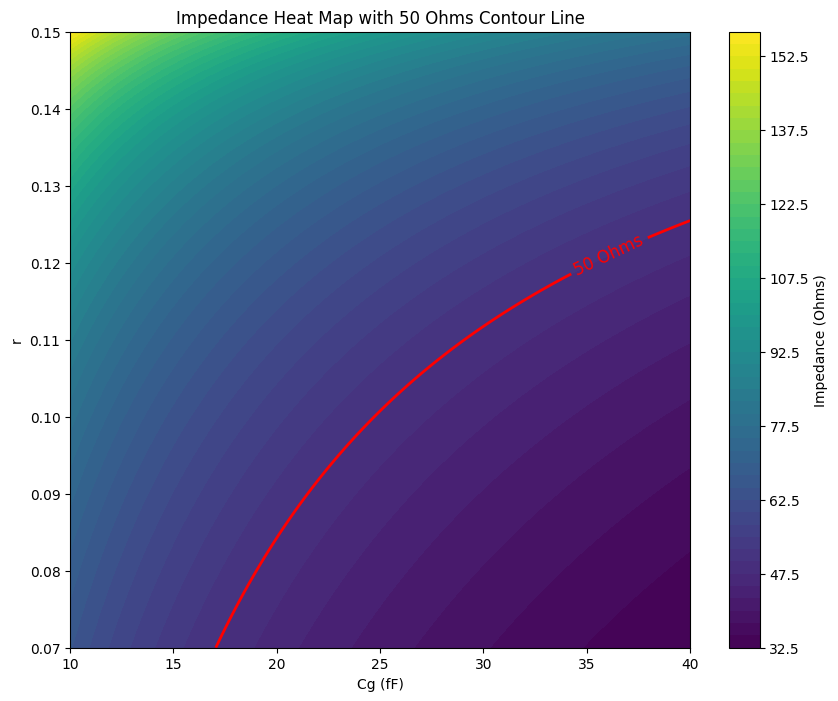

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize

h = 6.626e-34
e = 1.6e-19
Phi0 = h / (2 * e)

class MatchImpedance:
    """Class to solve for unit cell impedance. 
    Objective: find parameters to intrisically match 50 Ohm transmission line impedance.
    Model: Z0 = sqrt(L/Cg) where 
            L is solved below using Taylor expansion of SNAIL current equation and 
            Cg is capacitance to ground (ignores internal and junction capacitances).
    Parameters:
        Ic = critical current per unit area (uA / um^2)
        A = area of large junction (um^2)
        r_range = range of ratio values
        Cg_range = range of feasible ground capacitance values
    """
    def __init__(self, Ic, A, r_range, Cg_range):
        self.I0 = Ic*A
        self.r_range = r_range
        self.Cg_range = Cg_range
        self.Z_map = None
        self.R = None
        self.Cg = None
        self.optimal_flux = self.optimize_applied_flux()

    def optimize_applied_flux(self):
        # Search around half a flux quantum
        result = minimize(lambda flux: self.g4(flux), Phi0 / 2, bounds=[(Phi0 / 4, 3 * Phi0 / 4)])
        optimal_flux = result.x[0]
        return optimal_flux
    
    def phi_ext(self, applied_flux):
        return 2 * np.pi * applied_flux / Phi0

    def I(self, r, phi, phi_ext):
        return r * self.I0 * np.sin(phi) + self.I0 * np.sin(phi / 3 - phi_ext / 3)

    def solve_phi_star(self, applied_flux):
        phi_ext_value = self.phi_ext(applied_flux)
        phi_star = fsolve(lambda phi: self.I(self.r_range[0], phi, phi_ext_value), 0)[0]
        return phi_star

    def alpha(self, phi_star, phi_ext):
        return self.r_range * np.cos(phi_star) + np.cos(phi_star / 3 - phi_ext / 3) / 3

    def L(self, I0, a):
        return Phi0 / (2 * np.pi * I0 * a)

    def Z0(self, L, Cg):
        return np.sqrt(L / Cg)

    def gamma(self, r, phi_star, phi_ext):
        return (r * np.cos(phi_star) + r * np.sin((phi_star - phi_ext) / 3) / 27) / 6

    def g4(self, applied_flux):
        phi_star = self.solve_phi_star(applied_flux)
        phi_ext_value = self.phi_ext(applied_flux)
        gamma_values = self.gamma(self.r_range, phi_star, phi_ext_value)
        alpha_values = self.alpha(phi_star, phi_ext_value)
        g4_values = gamma_values / (alpha_values * self.Cg_range[:, None])
        return np.max(-g4_values)  # Find the maximum negative value

    def calculate_impedance(self):
        self.R, self.Cg = np.meshgrid(self.r_range, self.Cg_range)
        phi_star = self.solve_phi_star(self.optimal_flux)  # Assuming applied_flux=0
        a_values = self.alpha(phi_star, self.optimal_flux)  # Assuming phi_ext=0 for simplicity
        L_values = self.L(self.I0, a_values)
        self.Z_map = self.Z0(L_values, self.Cg)

    def plot_heatmap(self):
        if self.Z_map is None:
            self.calculate_impedance()
        
        plt.figure(figsize=(10, 8))
        plt.contourf(self.Cg * 1e15, self.R, self.Z_map, levels=50, cmap='viridis')
        cbar = plt.colorbar()
        cbar.set_label('Impedance (Ohms)')
        
        contour = plt.contour(self.Cg * 1e15, self.R, self.Z_map, levels=[50], colors='red', linewidths=2)
        plt.clabel(contour, inline=True, fontsize=12, fmt='50 Ohms')
        
        plt.xlabel('Cg (fF)')
        plt.ylabel('r')
        plt.title('Impedance Heat Map with 50 Ohms Contour Line')
        plt.show()

# Example usage:
Ic = 5e-6  # A/um^2
A = 2 * 8 # um^2
r_range = np.linspace(0.07, 0.15, 200)  # Range of r values
Cg_range = np.linspace(10e-15, 40e-15, 200)  # Range of Cg values

mi = MatchImpedance(Ic, A, r_range, Cg_range)
mi.plot_heatmap()